## 집단별 어떤 브랜드, 카테고리 제품의 푸시 알림을 보내는게 좋을까?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# "rfm.csv" 읽고 CustomerID 인덱스로 지정하기
df = pd.read_parquet('rfm_total.parquet.gzip')
df.shape

(228393, 9)

In [3]:
# Recency, Frequency, MonetaryValue 만 따로 rfm_cluster 변수에 담아 사용하기
rfm_cluster = df[['Recency', 'Frequency', 'MonetaryValue']]
print(rfm_cluster.shape)
rfm_cluster

(228393, 3)


,Recency,Frequency,MonetaryValue
user_id,,,
384989212,14,1,41.439999
401021311,11,1,231.639999
403013066,14,2,807.160034
410333972,1,1,591.250000
415873351,1,2,263.059998
...,...,...,...
566265448,1,1,592.010010
566267483,1,2,30.740000
566270060,1,2,147.419998


In [4]:
rfm_cluster.describe()

,Recency,Frequency,MonetaryValue
count,228393.000000,228393.000000,228393.000000
mean,14.339691,1.986742,737.289917
std,9.384898,3.243977,2003.170410
min,1.000000,1.000000,0.880000
25%,6.000000,1.000000,143.119995
50%,12.000000,1.000000,285.720001
75%,24.000000,2.000000,730.260010
max,31.000000,291.000000,198916.640625


<Axes: xlabel='Recency', ylabel='count'>

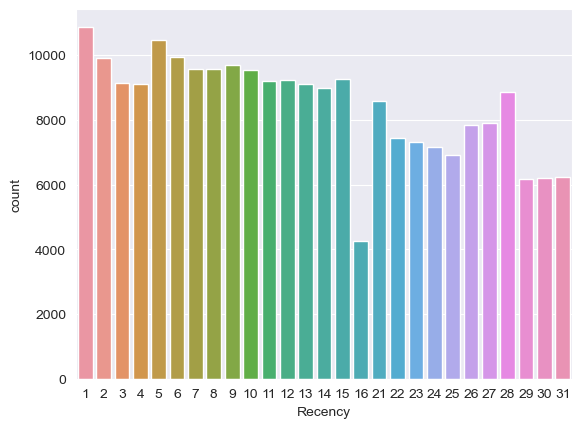

In [5]:
sns.countplot(data=df, x="Recency")

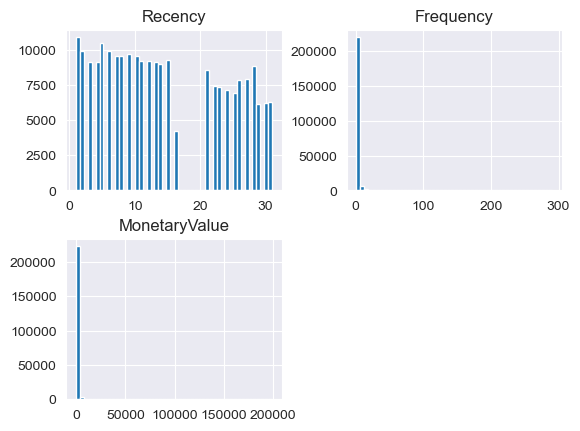

In [6]:
rfm_cluster.hist(bins=50);

In [7]:
# log 변환
# 회귀나 k-means에서 log 변환 시 성능이 조금 더 좋아짐

rfm_cluster_log = np.log(rfm_cluster + 1)
rfm_cluster_log.head()

,Recency,Frequency,MonetaryValue
user_id,,,
384989212,2.708050,0.693147,3.748091
401021311,2.484907,0.693147,5.449492
403013066,2.708050,1.098612,6.694760
410333972,0.693147,0.693147,6.383929
415873351,0.693147,1.098612,5.576176


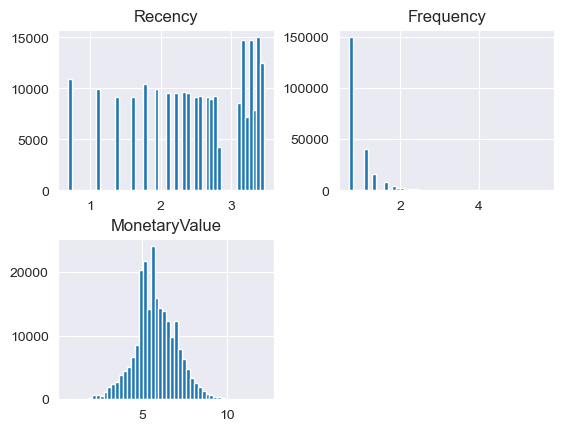

In [8]:
rfm_cluster_log.hist(bins=50);

In [9]:
rfm_cluster_log.describe()

,Recency,Frequency,MonetaryValue
count,228393.000000,228393.000000,228393.000000
mean,2.482504,0.944337,5.765843
std,0.774222,0.441100,1.240259
min,0.693147,0.693147,0.631272
25%,1.945910,0.693147,4.970646
50%,2.564949,0.693147,5.658506
75%,3.218876,1.098612,6.594769
max,3.465736,5.676754,12.200646


## 스케일링

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

scaler = StandardScaler()
X = scaler.fit_transform(rfm_cluster_log)
X

array([[ 0.29132083, -0.56946415, -1.62675977],
       [ 0.00310372, -0.56946415, -0.2550502 ],
       [ 0.29132083,  0.34975059,  0.74891462],
       ...,
       [-2.31117221,  0.34975059, -0.61740398],
       [-2.31117221, -0.56946415,  1.48454329],
       [-2.31117221, -0.56946415,  1.33025895]])

In [11]:
# 데이터 프레임으로 저장
pd.DataFrame(X).describe().round(2)

,0,1,2
count,228393.00,228393.00,228393.00
mean,-0.00,-0.00,-0.00
std,1.00,1.00,1.00
min,-2.31,-0.57,-4.14
25%,-0.69,-0.57,-0.64
50%,0.11,-0.57,-0.09
75%,0.95,0.35,0.67
max,1.27,10.73,5.19


## KMeans

In [12]:
from sklearn.cluster import KMeans
from tqdm import tqdm
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

inertia = [] # 같은 애들끼리 얼마나 똘똘 뭉쳐있는지
silhouettes = []
range_n_clusters = range(2, 10)

for n_cluster in tqdm(range(2, 10)):
    kmeans = KMeans(n_clusters=n_cluster, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X, labels=kmeans.labels_))
    print(n_cluster, end=',')

 12%|██████████▏                                                                      | 1/8 [12:39<1:28:34, 759.16s/it]

2,

 25%|████████████████████▎                                                            | 2/8 [25:05<1:15:11, 751.91s/it]

3,

 38%|██████████████████████████████▍                                                  | 3/8 [36:55<1:01:03, 732.66s/it]

4,

 50%|█████████████████████████████████████████▌                                         | 4/8 [51:10<52:03, 780.86s/it]

5,

 62%|██████████████████████████████████████████████████▋                              | 5/8 [1:05:24<40:21, 807.08s/it]

6,

 75%|████████████████████████████████████████████████████████████▊                    | 6/8 [1:20:28<28:00, 840.10s/it]

7,

 88%|██████████████████████████████████████████████████████████████████████▉          | 7/8 [1:31:55<13:09, 789.96s/it]

8,

100%|█████████████████████████████████████████████████████████████████████████████████| 8/8 [1:43:27<00:00, 775.96s/it]

9,

## Elbow Method

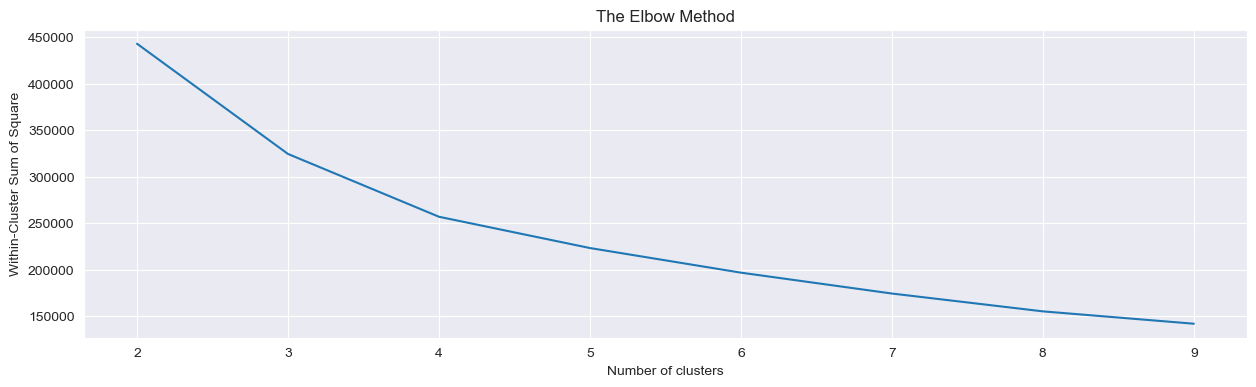

In [13]:
plt.figure(figsize=(15,4))
plt.plot(range_n_clusters, inertia)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster Sum of Square')
plt.xticks(range_n_clusters)
plt.show()

## Silhouette Score

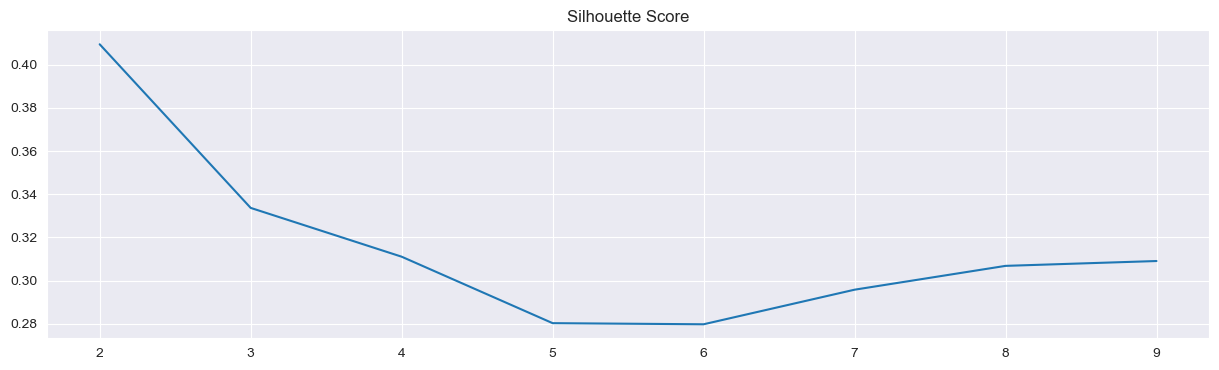

In [14]:
plt.figure(figsize=(15, 4))
plt.title('Silhouette Score')
plt.plot(range_n_clusters, silhouettes)
plt.xticks(range_n_clusters)
plt.show()

## KElbowVisualizer

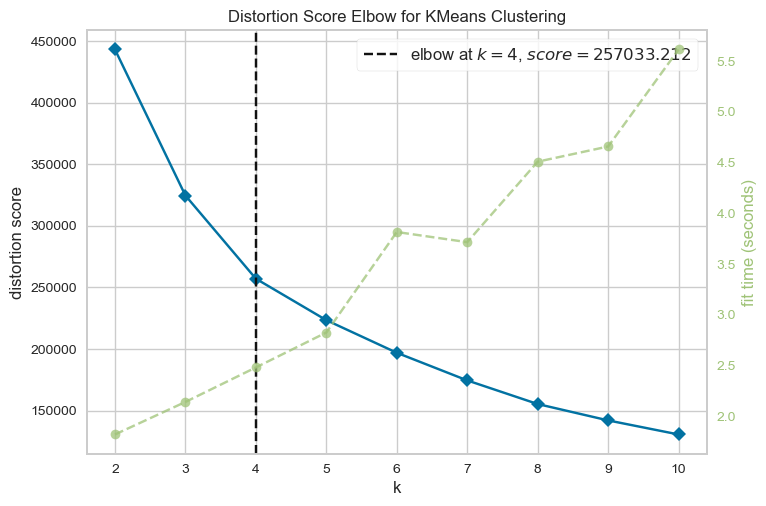

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
# yellowbrick.cluster 에서 KElbowVisualizer 불러오기
from yellowbrick.cluster import KElbowVisualizer

KEV = KElbowVisualizer(kmeans, k=10, n_init="auto")
KEV.fit(X)
KEV.show()

## 분석한 내용을 바탕으로 KMeans n_clusters 값을 정해 학습하기

In [16]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X)

KMeans(n_clusters=4, random_state=42)

In [17]:
kmeans.labels_

array([1, 1, 3, ..., 0, 0, 0])

In [18]:
pd.Series(kmeans.labels_).value_counts()

1    82882
3    66557
0    55713
2    23241
dtype: int64

In [19]:
# silhouette_score 구하기
silhouette_avg = silhouette_score(X, kmeans.labels_)
silhouette_avg

0.3110341979699567

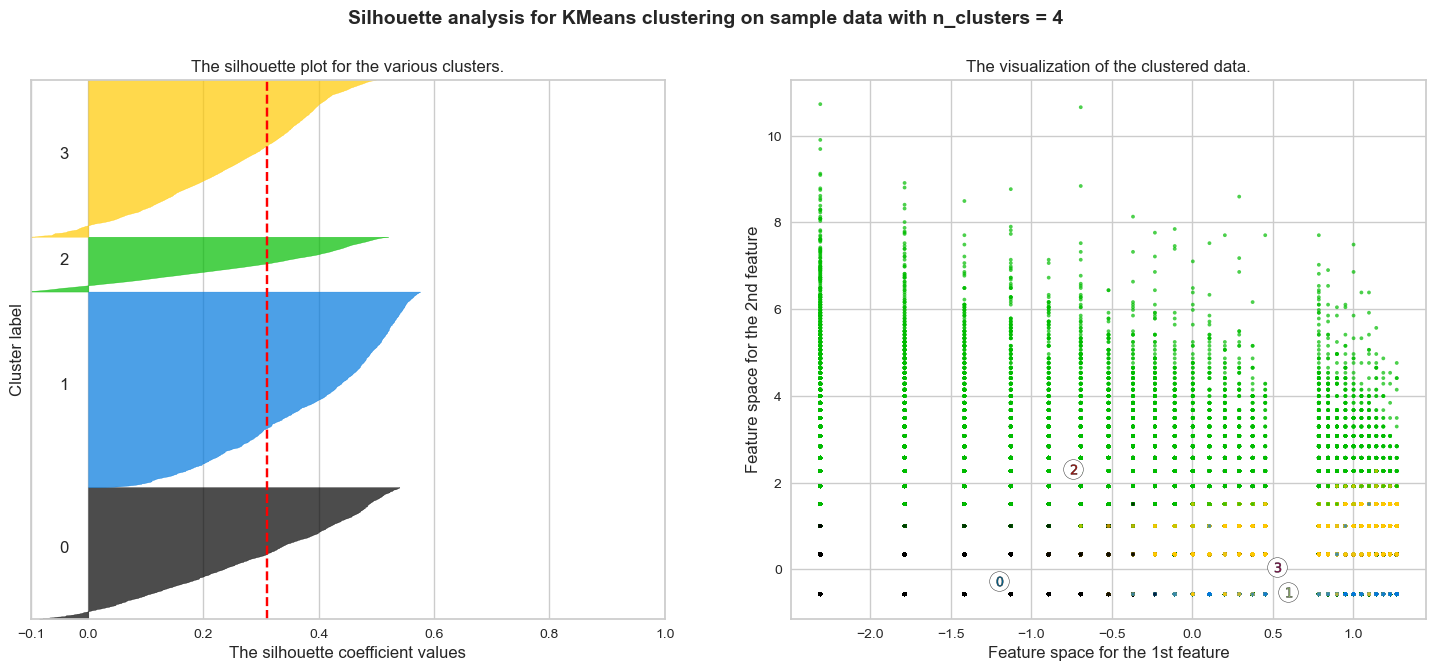

In [20]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
cluster_labels = kmeans.labels_
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(
    X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
)

# Labeling the clusters
centers = kmeans.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
)

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(
    "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
    % n_clusters,
    fontsize=14,
    fontweight="bold",
)

plt.show()

In [21]:
df['Cluster'] = kmeans.labels_
df.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class,Cluster
user_id,,,,,,,,,,
384989212,14,1,41.439999,3,1,1,311,5,silver,1
401021311,11,1,231.639999,3,1,3,313,7,silver,1
403013066,14,2,807.160034,3,4,4,344,11,platinum,3
410333972,1,1,591.250000,5,1,4,514,10,gold,0
415873351,1,2,263.059998,5,4,3,543,12,platinum,0


In [22]:
df_reset = df.reset_index()
df_reset

,user_id,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class,Cluster
0,384989212,14,1,41.439999,3,1,1,311,5,silver,1
1,401021311,11,1,231.639999,3,1,3,313,7,silver,1
2,403013066,14,2,807.160034,3,4,4,344,11,platinum,3
3,410333972,1,1,591.250000,5,1,4,514,10,gold,0
4,415873351,1,2,263.059998,5,4,3,543,12,platinum,0
...,...,...,...,...,...,...,...,...,...,...,...
228388,566265448,1,1,592.010010,5,4,4,544,13,platinum,0
228389,566267483,1,2,30.740000,5,5,1,551,11,platinum,0
228390,566270060,1,2,147.419998,5,5,2,552,12,platinum,0
228391,566274637,1,1,2011.630005,5,4,5,545,14,platinum,0


In [23]:
# class를 qcut으로 구한거랑 머신러닝으로 구한 것 비교
pd.crosstab(df['RFM_class'], df['Cluster'])

Cluster,0,1,2,3
RFM_class,,,,
silver,4702,66581,2,9011
gold,25345,16292,105,33774
platinum,25666,9,23134,23772


In [24]:
rfm_cluster_log

,Recency,Frequency,MonetaryValue
user_id,,,
384989212,2.708050,0.693147,3.748091
401021311,2.484907,0.693147,5.449492
403013066,2.708050,1.098612,6.694760
410333972,0.693147,0.693147,6.383929
415873351,0.693147,1.098612,5.576176
...,...,...,...
566265448,0.693147,0.693147,6.385211
566267483,0.693147,1.098612,3.457578
566270060,0.693147,1.098612,5.000046


In [25]:
scaler = StandardScaler()
rfm_cluster_log[['Recency','Frequency','MonetaryValue']] = scaler.fit_transform(rfm_cluster_log[['Recency','Frequency','MonetaryValue']])
rfm_cluster_log.head()

,Recency,Frequency,MonetaryValue
user_id,,,
384989212,0.291321,-0.569464,-1.626760
401021311,0.003104,-0.569464,-0.255050
403013066,0.291321,0.349751,0.748915
410333972,-2.311172,-0.569464,0.498315
415873351,-2.311172,0.349751,-0.152914


### user들이 많이 본 제품

In [26]:
# 전체 데이터프레임 total에 저장
total = pd.read_parquet('df_total.parquet.gzip')
total.head()

,event_time,event_type,product_id,category_code,brand,price,user_id
0,2019-10-16 12:04:37+00:00,view,7900918,furniture.kitchen.chair,joie,102.709999,560842110
1,2019-10-16 12:04:37+00:00,view,1003317,electronics.smartphone,apple,952.150024,560842739
2,2019-10-16 12:04:37+00:00,view,2501929,appliances.kitchen.oven,asel,61.750000,525817175
3,2019-10-16 12:04:37+00:00,view,1004833,electronics.smartphone,samsung,172.169998,515456548
4,2019-10-16 12:04:37+00:00,cart,1004836,electronics.smartphone,samsung,229.410004,529758564


In [27]:
total.shape

(22146517, 7)

In [28]:
# event_type이 view
df_view = total[total['event_type'] == 'view']
df_view

,event_time,event_type,product_id,category_code,brand,price,user_id
0,2019-10-16 12:04:37+00:00,view,7900918,furniture.kitchen.chair,joie,102.709999,560842110
1,2019-10-16 12:04:37+00:00,view,1003317,electronics.smartphone,apple,952.150024,560842739
2,2019-10-16 12:04:37+00:00,view,2501929,appliances.kitchen.oven,asel,61.750000,525817175
3,2019-10-16 12:04:37+00:00,view,1004833,electronics.smartphone,samsung,172.169998,515456548
6,2019-10-16 12:04:37+00:00,view,1500447,computers.peripherals.printer,hp,136.169998,544343611
...,...,...,...,...,...,...,...
7074788,2019-10-11 17:54:47+00:00,view,3601261,appliances.kitchen.washer,bosch,476.119995,515598105
7074789,2019-10-11 17:54:47+00:00,view,2800660,appliances.kitchen.refrigerators,dauscher,156.220001,557716137
7074791,2019-10-11 17:54:47+00:00,view,4900396,appliances.kitchen.juicer,bosch,101.389999,522609644
7074792,2019-10-11 17:54:47+00:00,view,1801350,electronics.video.tv,toshiba,437.510010,505550850


In [29]:
# 제일 많이 view된 제품 id를 찾음
df_view.groupby(['product_id'])[['user_id']].count().sort_values(by='user_id', ascending=False)

,user_id
product_id,
1004856,352660
1004767,319501
1005115,274762
1004249,172483
1004833,168744
...,...
13900992,1
13900990,1
35108728,1


In [30]:
# 사람들이 가장 많이 본(view) 상위 5개의 product_id 구하기
# 결과: 1004856, 1004767, 1005115, 1004249, 1004833번 product
idx = df_view.groupby(['product_id'])[['user_id']].count().sort_values(by='user_id', ascending=False).head(5).index
idx

Int64Index([1004856, 1004767, 1005115, 1004249, 1004833], dtype='int64', name='product_id')

In [31]:
idx = idx.to_list() # 리스트로 변환

In [32]:
view_max = df_view[df_view['product_id'].isin(idx)][['category_code', 'brand', 'user_id','product_id']]
view_max # 위 결과에서 나온 product_id의 일부 컬럼만 출력

,category_code,brand,user_id,product_id
3,electronics.smartphone,samsung,515456548,1004833
14,electronics.smartphone,samsung,534900903,1004856
18,electronics.smartphone,samsung,513747311,1004856
49,electronics.smartphone,samsung,560838312,1004856
94,electronics.smartphone,samsung,514791097,1004856
...,...,...,...,...
7074661,electronics.smartphone,samsung,542522794,1004856
7074702,electronics.smartphone,samsung,518985190,1004767
7074704,electronics.smartphone,samsung,516643465,1004833
7074706,electronics.smartphone,samsung,559253574,1004856


<Axes: >

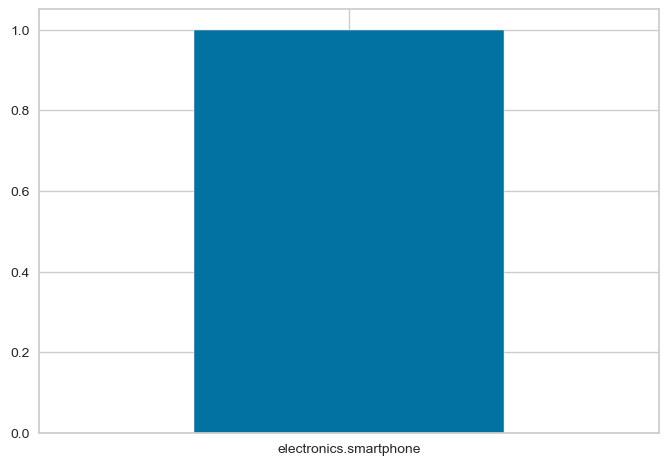

In [33]:
view_max['category_code'].value_counts(1).plot.bar(rot=0)
# electronics.smartphone이 거의 90퍼센트

<Axes: >

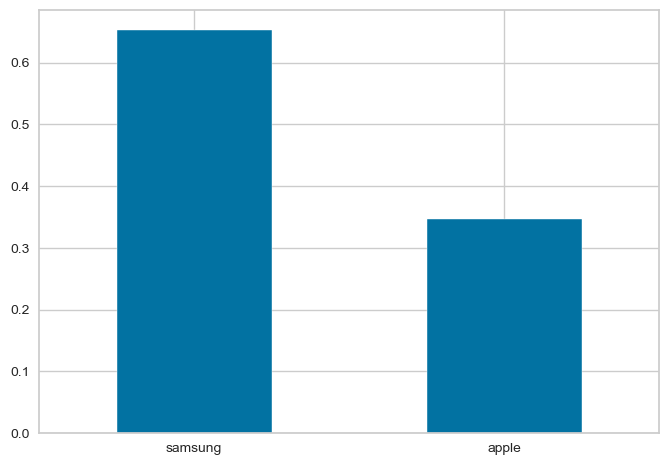

In [34]:
view_max['brand'].value_counts(1).plot.bar(rot=0) 
# smartphone 브랜드 samsumg, apple 순으로 높음

### 많이 본 제품(스마트폰)이 구매로 이어지지는 않았을까?

#### 몇 퍼센트의 사용자들이 구매했을까?

In [35]:
view_max.head()

,category_code,brand,user_id,product_id
3,electronics.smartphone,samsung,515456548,1004833
14,electronics.smartphone,samsung,534900903,1004856
18,electronics.smartphone,samsung,513747311,1004856
49,electronics.smartphone,samsung,560838312,1004856
94,electronics.smartphone,samsung,514791097,1004856


In [36]:
# view_max는 view의 top5에 해당하는 제품들
# view의 top5에 해당하는 제품들을 본 총 사람 수
view_max['user_id'].nunique()

480327

In [37]:
# 리스트로 변환
user = view_max['user_id'].to_list()
user[:5]

[515456548, 534900903, 513747311, 560838312, 514791097]

In [38]:
# 원본 데이터에서 user_id가 위의 user 리스트인 사람 & event_type이 purchase인 경우
df_user = total[(total['user_id'].isin(user)) & (total['event_type'] == 'purchase') ]
df_user

,event_time,event_type,product_id,category_code,brand,price,user_id
178,2019-10-16 12:04:46+00:00,purchase,1005105,electronics.smartphone,apple,1424.209961,514778102
214,2019-10-16 12:04:48+00:00,purchase,1002544,electronics.smartphone,apple,460.109985,522354527
295,2019-10-16 12:04:52+00:00,purchase,1003312,electronics.smartphone,apple,699.799988,517222549
479,2019-10-16 12:05:03+00:00,purchase,1005135,electronics.smartphone,apple,1741.359985,536590960
572,2019-10-16 12:05:07+00:00,purchase,1004835,electronics.smartphone,samsung,225.190002,517728689
...,...,...,...,...,...,...,...
7074097,2019-10-11 17:54:18+00:00,purchase,1004249,electronics.smartphone,apple,766.760010,559250735
7074469,2019-10-11 17:54:34+00:00,purchase,1003235,electronics.smartphone,huawei,128.419998,559189082
7074484,2019-10-11 17:54:35+00:00,purchase,1005112,electronics.smartphone,apple,1003.849976,512404459
7074507,2019-10-11 17:54:35+00:00,purchase,1005115,electronics.smartphone,apple,1003.849976,540273893


In [39]:
view_max

,category_code,brand,user_id,product_id
3,electronics.smartphone,samsung,515456548,1004833
14,electronics.smartphone,samsung,534900903,1004856
18,electronics.smartphone,samsung,513747311,1004856
49,electronics.smartphone,samsung,560838312,1004856
94,electronics.smartphone,samsung,514791097,1004856
...,...,...,...,...
7074661,electronics.smartphone,samsung,542522794,1004856
7074702,electronics.smartphone,samsung,518985190,1004767
7074704,electronics.smartphone,samsung,516643465,1004833
7074706,electronics.smartphone,samsung,559253574,1004856


In [40]:
pd.merge(view_max, df_user, on=['product_id', 'user_id'], how='inner')['user_id']

0         560836294
1         560836294
2         560836294
3         514128238
4         514128238
            ...    
597634    515800764
597635    540273893
597636    540273893
597637    512723560
597638    512723560
Name: user_id, Length: 597639, dtype: int64

In [41]:
a = pd.merge(view_max, df_user, on=['product_id', 'user_id'], how='inner')
a

,category_code_x,brand_x,user_id,product_id,event_time,event_type,category_code_y,brand_y,price
0,electronics.smartphone,samsung,560836294,1004856,2019-10-16 12:08:41+00:00,purchase,electronics.smartphone,samsung,131.639999
1,electronics.smartphone,samsung,560836294,1004856,2019-10-16 12:08:41+00:00,purchase,electronics.smartphone,samsung,131.639999
2,electronics.smartphone,samsung,560836294,1004856,2019-10-16 12:08:41+00:00,purchase,electronics.smartphone,samsung,131.639999
3,electronics.smartphone,samsung,514128238,1004856,2019-10-24 05:44:28+00:00,purchase,electronics.smartphone,samsung,131.509995
4,electronics.smartphone,samsung,514128238,1004856,2019-10-24 05:44:28+00:00,purchase,electronics.smartphone,samsung,131.509995
...,...,...,...,...,...,...,...,...,...
597634,electronics.smartphone,apple,515800764,1005115,2019-10-11 17:49:22+00:00,purchase,electronics.smartphone,apple,1003.849976
597635,electronics.smartphone,apple,540273893,1005115,2019-10-11 17:54:35+00:00,purchase,electronics.smartphone,apple,1003.849976
597636,electronics.smartphone,apple,540273893,1005115,2019-10-11 17:54:35+00:00,purchase,electronics.smartphone,apple,1003.849976
597637,electronics.smartphone,samsung,512723560,1004833,2019-10-11 17:52:37+00:00,purchase,electronics.smartphone,samsung,172.220001


In [42]:
# view가 top5인 상품을 담은 view_max와 위의 df_user를 결합하여 user_id 추출 
pd.merge(view_max, df_user, on=['product_id', 'user_id'], how='inner')['user_id'].nunique()

42906

In [43]:
42906 / 480327* 100 # 8.9%의 user만 구매함

8.932664622226108

#### 집단별 구매전환율

In [44]:
r = df_reset[['user_id', 'Cluster']]
r

,user_id,Cluster
0,384989212,1
1,401021311,1
2,403013066,3
3,410333972,0
4,415873351,0
...,...,...
228388,566265448,0
228389,566267483,0
228390,566270060,0
228391,566274637,0


In [45]:
i = pd.merge(a, r, on='user_id', how='left')[['user_id', 'Cluster']]
i

,user_id,Cluster
0,560836294,1
1,560836294,1
2,560836294,1
3,514128238,1
4,514128238,1
...,...,...
597634,515800764,3
597635,540273893,3
597636,540273893,3
597637,512723560,1


In [46]:
i.drop_duplicates(['user_id'])['Cluster'].value_counts(1).sort_index()

0    0.218081
1    0.274064
2    0.216520
3    0.291335
Name: Cluster, dtype: float64

<Axes: >

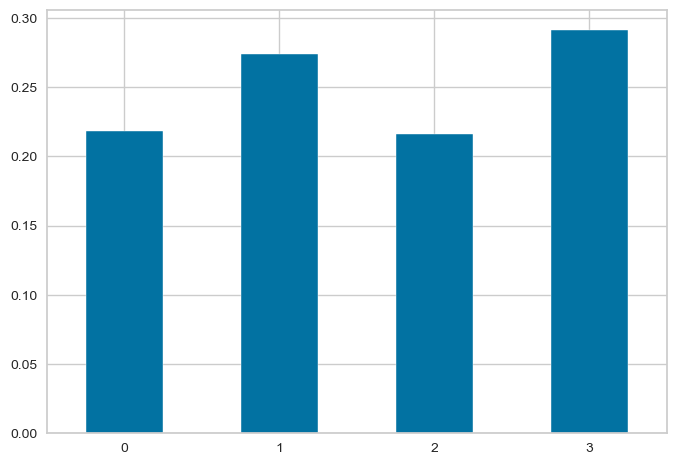

In [47]:
# 집단별 많이 본 물건 구매율 비교
i.drop_duplicates(['user_id'])['Cluster'].value_counts(1).sort_index().plot.bar(rot=0)

⇒ 0번이나 2번 집단의 사람들은 1,3번 집단의 사람들에 비해 view top5 물건(스마트폰)을 본 후 구매로 전환되지 않았다.

⇒ 0번, 2번 집단에 스마트폰 푸시 알람을 보내 구매를 장려

### 장바구니에 많이 담긴 제품은?

In [48]:
# 전체 데이터프레임
total = pd.read_parquet('df_total.parquet.gzip')
total.head()

,event_time,event_type,product_id,category_code,brand,price,user_id
0,2019-10-16 12:04:37+00:00,view,7900918,furniture.kitchen.chair,joie,102.709999,560842110
1,2019-10-16 12:04:37+00:00,view,1003317,electronics.smartphone,apple,952.150024,560842739
2,2019-10-16 12:04:37+00:00,view,2501929,appliances.kitchen.oven,asel,61.750000,525817175
3,2019-10-16 12:04:37+00:00,view,1004833,electronics.smartphone,samsung,172.169998,515456548
4,2019-10-16 12:04:37+00:00,cart,1004836,electronics.smartphone,samsung,229.410004,529758564


In [49]:
total.shape

(22146517, 7)

In [50]:
df_cart = total[total['event_type'] == 'cart']
df_cart

,event_time,event_type,product_id,category_code,brand,price,user_id
4,2019-10-16 12:04:37+00:00,cart,1004836,electronics.smartphone,samsung,229.410004,529758564
64,2019-10-16 12:04:40+00:00,cart,5100562,electronics.clocks,apple,295.750000,512938489
65,2019-10-16 12:04:40+00:00,cart,1201460,electronics.tablet,apple,514.500000,560842390
79,2019-10-16 12:04:41+00:00,cart,45300027,kids.swing,pituso,89.669998,559176425
87,2019-10-16 12:04:41+00:00,cart,1002524,electronics.smartphone,apple,537.719971,525093135
...,...,...,...,...,...,...,...
7074141,2019-10-11 17:54:20+00:00,cart,6700581,computers.components.videocards,palit,165.279999,516001171
7074207,2019-10-11 17:54:23+00:00,cart,1005112,electronics.smartphone,apple,1003.849976,542072341
7074345,2019-10-11 17:54:29+00:00,cart,8800093,electronics.telephone,nokia,50.189999,539136718
7074498,2019-10-11 17:54:35+00:00,cart,8800048,electronics.telephone,nokia,22.250000,558723618


In [51]:
df_cart.groupby(['product_id'])[['user_id']].count().sort_values(by='user_id', ascending=False)

,user_id
product_id,
1004856,41201
1004767,29802
4804056,18300
1004833,17012
1004870,15500
...,...
2800658,1
9900224,1
1701029,1


In [52]:
# product_id 구하기
idx = df_cart.groupby(['product_id'])[['user_id']].count().sort_values(by='user_id', ascending=False).head().index
idx

Int64Index([1004856, 1004767, 4804056, 1004833, 1004870], dtype='int64', name='product_id')

In [53]:
idx = idx.to_list()

In [54]:
cart_max = df_cart[df_cart['product_id'].isin(idx)][['category_code', 'brand', 'user_id','product_id']]
cart_max

,category_code,brand,user_id,product_id
92,electronics.smartphone,samsung,560838312,1004856
418,electronics.smartphone,samsung,529278312,1004767
492,electronics.smartphone,samsung,560836294,1004856
551,electronics.audio.headphone,apple,557484115,4804056
591,electronics.smartphone,samsung,518856168,1004833
...,...,...,...,...
7071001,electronics.smartphone,samsung,512723560,1004833
7071434,electronics.smartphone,samsung,516853554,1004767
7071606,electronics.smartphone,samsung,521640125,1004767
7071676,electronics.smartphone,samsung,516853554,1004767


<Axes: >

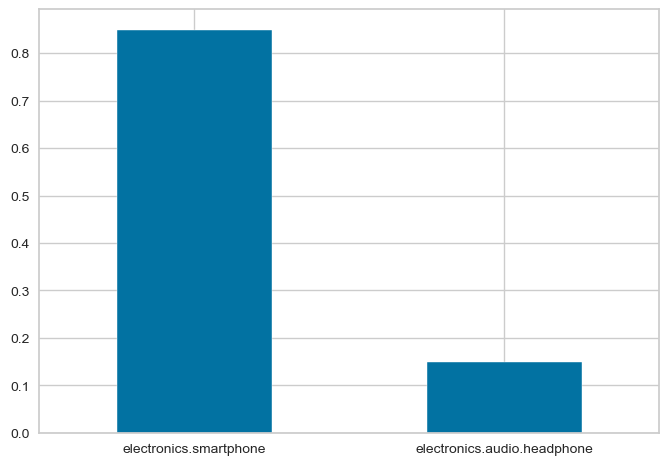

In [55]:
# 장바구니에 많이 담긴 top5 제품의 카테고리 보기
cart_max['category_code'].value_counts(1).plot.bar(rot=0) # smartphone, audio.headphone

<Axes: >

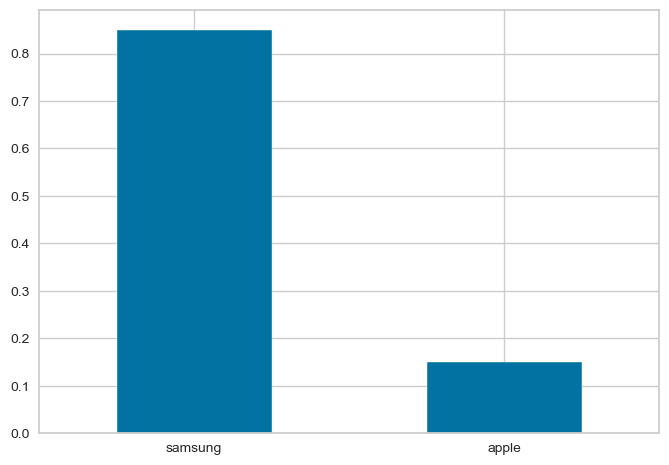

In [56]:
cart_max['brand'].value_counts(1).plot.bar(rot=0) # samsumg, apple 순으로 높음
# 스마트폰, 헤드폰 모두 다양한 브랜드가 있는데 브랜드로 삼성과 애플만 나온 것이 신기했다.

In [57]:
total[total['category_code'] == 'electronics.audio.headphone']['brand'].unique()

array(['apple', 'huawei', 'samsung', 'xiaomi', 'harper', 'jbl', 'olmio',
       'sony', 'canyon', 'jabra', 'elari', 'bose', 'defender',
       'plantronics', 'panasonic', 'hoco', 'sennheiser', 'hyperx',
       'marley', 'koss', 'audio-technica', 'usams', 'logitech',
       'marshall', 'acme', 'awei', 'manhattan', 'razer', 'hp', 'trust',
       'ritmix', 'acqua', 'inkax', 'steelseries', 'akg', 'olto', 'rapoo',
       'beats', 'microlab', 'acer', 'meizu', 'global', 'philips',
       'kingston', 'lenovo', 'asus', 'nokia', 'fiio', 'yamaha', 'dunu',
       'remax', 'edifier', 'redragon', 'denn', 'shure', 'beyerdynamic',
       'parrot', 'cowon', 'sven', 'joyroom', 'vox', 'ergo', 'intro',
       'cnd', 'wuw', 'havit', 'fender', 'honor', 'soundking', 'alesis',
       'behringer', 'orico', 'samson', 'superlux', 'fostex', 'crown',
       'jvc', 'pioneer', 'hercules', 'genius', 'urbanears', 'gembird',
       'rombica', 'qcyber', 'lg', 'ipipoo', 'recci', 'continent', 'veho',
       'monster', 'sk

### 장바구니에 많이 담긴 제품이 구매로 이어지지는 않았을까?

#### 몇 퍼센트의 사용자들이 구매했을까?

In [58]:
# cart top5에 해당하는 제품들을 본 총 사용자 수
cart_max['user_id'].nunique()

56438

In [59]:
# 리스트로 변환
user = cart_max['user_id'].to_list()
user[:5]

[560838312, 529278312, 560836294, 557484115, 518856168]

In [60]:
# 원본 데이터에서 user_id가 위의 user 리스트에 있는 사람 & event_type이 purchase인 경우를 추출
df_user = total[(total['user_id'].isin(user)) & (total['event_type'] == 'purchase')]
df_user

,event_time,event_type,product_id,category_code,brand,price,user_id
214,2019-10-16 12:04:48+00:00,purchase,1002544,electronics.smartphone,apple,460.109985,522354527
295,2019-10-16 12:04:52+00:00,purchase,1003312,electronics.smartphone,apple,699.799988,517222549
572,2019-10-16 12:05:07+00:00,purchase,1004835,electronics.smartphone,samsung,225.190002,517728689
907,2019-10-16 12:05:23+00:00,purchase,1004856,electronics.smartphone,samsung,131.639999,548518784
1095,2019-10-16 12:05:33+00:00,purchase,1004833,electronics.smartphone,samsung,172.169998,518856168
...,...,...,...,...,...,...,...
7072250,2019-10-11 17:52:57+00:00,purchase,1004767,electronics.smartphone,samsung,250.880005,518902557
7072641,2019-10-11 17:53:14+00:00,purchase,1004856,electronics.smartphone,samsung,130.479996,558845757
7073793,2019-10-11 17:54:05+00:00,purchase,1004785,electronics.smartphone,huawei,272.049988,559132868
7073974,2019-10-11 17:54:12+00:00,purchase,1004962,electronics.smartphone,nokia,128.490005,553843399


In [61]:
pd.merge(cart_max, df_user, on=['product_id', 'user_id'], how='inner')['user_id'].nunique()

34110

In [62]:
34110 / 56438 * 100

60.43800276409511

⇒ cart top5에 해당하는 상품을 장바구니에 담은 사용자의 60.4%가 구매를 한 것으로 나타남

#### 집단별 구매전환율 분석

In [63]:
a = pd.merge(cart_max, df_user, on=['product_id', 'user_id'], how='inner')
r = df_reset[['user_id', 'Cluster']]

In [64]:
i = pd.merge(a, r, on='user_id', how='left')[['user_id', 'Cluster']]

In [65]:
i.drop_duplicates(['user_id'])['Cluster'].value_counts(1).sort_index()

0    0.227968
1    0.354559
2    0.198446
3    0.219027
Name: Cluster, dtype: float64

<Axes: >

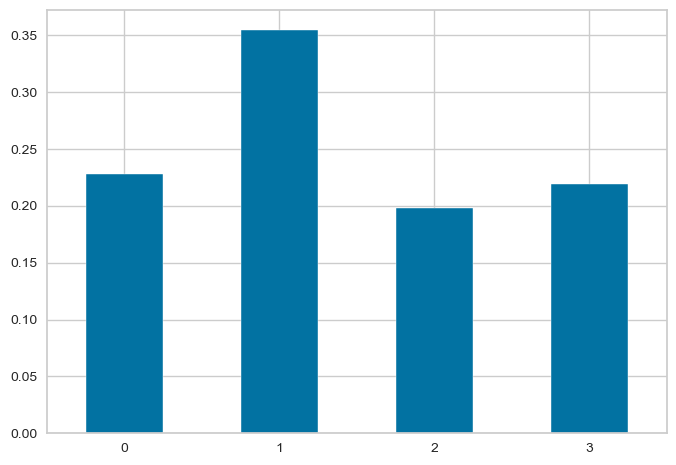

In [66]:
# 장바구니에 담아둔 물건 구매율은 1번 집단이 높은 수치를 보였다.
i.drop_duplicates(['user_id'])['Cluster'].value_counts(1).sort_index().plot.bar(rot=0)

⇒ 장바구니에 담아둔 물건 구매율은 1번 집단이 높은 수치를 보였다.

⇒ 0번, 2번, 3번 집단에 푸시 알람을 보내 장바구니에 담아둔 물건(스마트폰, 헤드폰) 구매를 장려

### 집단별 많이 구매한 브랜드 or 카테고리
#### 0번 집단

In [67]:
clu0 = df[df['Cluster'] == 0]
clu0

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class,Cluster
user_id,,,,,,,,,,
410333972,1,1,591.250000,5,1,4,514,10,gold,0
415873351,1,2,263.059998,5,4,3,543,12,platinum,0
418115333,4,1,127.419998,5,1,1,511,7,silver,0
430524990,3,1,130.990005,5,1,1,511,7,silver,0
431897261,4,1,463.329987,5,1,4,514,10,gold,0
...,...,...,...,...,...,...,...,...,...,...
566265448,1,1,592.010010,5,4,4,544,13,platinum,0
566267483,1,2,30.740000,5,5,1,551,11,platinum,0
566270060,1,2,147.419998,5,5,2,552,12,platinum,0


<Axes: >

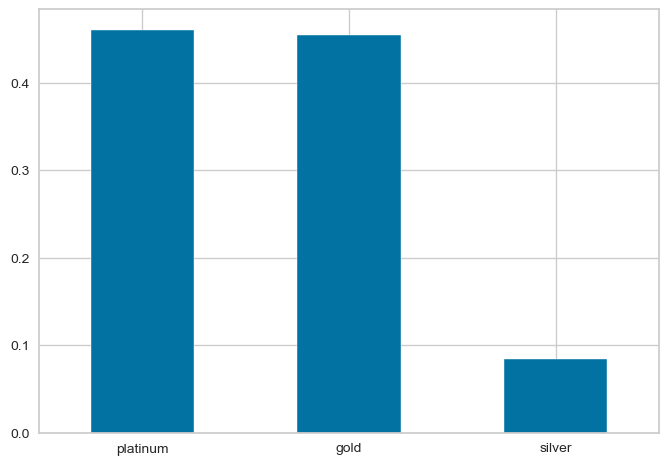

In [68]:
clu0['RFM_class'].value_counts(1).plot.bar(rot=0) # 0번 클러스터에는 platinum 고객이 많음

In [69]:
clu0 = clu0.reset_index()
clu0

,user_id,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class,Cluster
0,410333972,1,1,591.250000,5,1,4,514,10,gold,0
1,415873351,1,2,263.059998,5,4,3,543,12,platinum,0
2,418115333,4,1,127.419998,5,1,1,511,7,silver,0
3,430524990,3,1,130.990005,5,1,1,511,7,silver,0
4,431897261,4,1,463.329987,5,1,4,514,10,gold,0
...,...,...,...,...,...,...,...,...,...,...,...
55708,566265448,1,1,592.010010,5,4,4,544,13,platinum,0
55709,566267483,1,2,30.740000,5,5,1,551,11,platinum,0
55710,566270060,1,2,147.419998,5,5,2,552,12,platinum,0
55711,566274637,1,1,2011.630005,5,4,5,545,14,platinum,0


In [70]:
idx0 = clu0['user_id'].to_list()
idx0[:5]

[410333972, 415873351, 418115333, 430524990, 431897261]

In [71]:
df_user0 = total[(total['event_type'] == 'purchase') & (total['user_id'].isin(idx0))]
df_user0

,event_time,event_type,product_id,category_code,brand,price,user_id
7,2019-10-16 12:04:38+00:00,purchase,3601438,appliances.kitchen.washer,beko,203.410004,512935426
333,2019-10-16 12:04:54+00:00,purchase,5100562,electronics.clocks,apple,295.750000,512938489
1551,2019-10-16 12:05:54+00:00,purchase,2800590,appliances.kitchen.refrigerators,dauscher,334.369995,548085506
3398,2019-10-16 12:07:27+00:00,purchase,3701428,appliances.environment.vacuum,arnica,69.239998,532727338
5151,2019-10-16 12:08:50+00:00,purchase,1004870,electronics.smartphone,samsung,287.649994,514669514
...,...,...,...,...,...,...,...
7053676,2019-10-11 17:40:01+00:00,purchase,13901530,construction.components.faucet,grohe,101.199997,518110521
7053893,2019-10-11 17:40:11+00:00,purchase,1004776,electronics.smartphone,xiaomi,183.270004,525086132
7061563,2019-10-11 17:45:38+00:00,purchase,4802401,electronics.audio.headphone,samsung,43.860001,515986744
7065813,2019-10-11 17:48:33+00:00,purchase,4804056,electronics.audio.headphone,apple,160.880005,515986744


<Axes: >

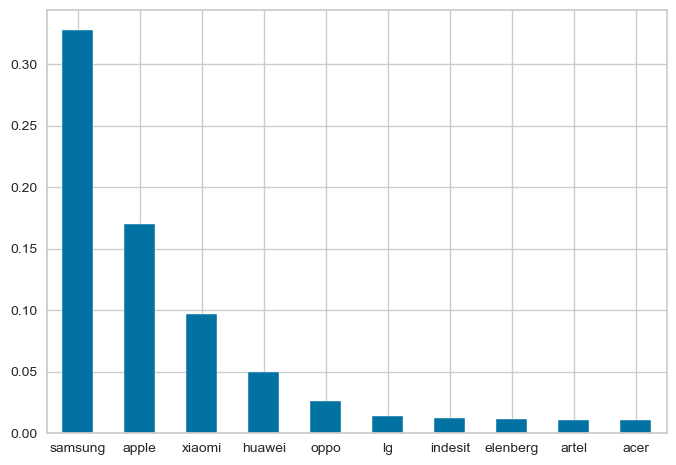

In [72]:
df_user0['brand'].value_counts(1).head(10).plot.bar(rot=0)

<Axes: >

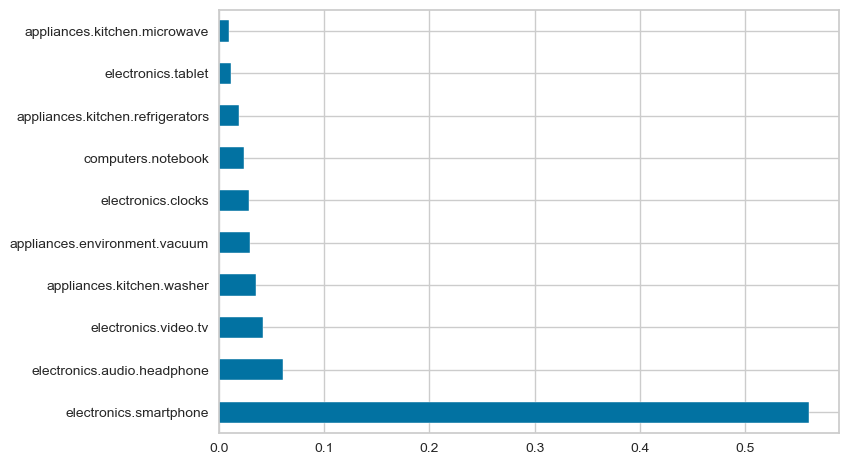

In [73]:
df_user0['category_code'].value_counts(1).head(10).plot.barh(rot=0)

#### 1번 집단

In [74]:
clu1 = df[df['Cluster'] == 1]
clu1

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class,Cluster
user_id,,,,,,,,,,
384989212,14,1,41.439999,3,1,1,311,5,silver,1
401021311,11,1,231.639999,3,1,3,313,7,silver,1
424869855,8,1,88.290001,4,1,1,411,6,silver,1
431246706,9,1,170.830002,4,1,2,412,7,silver,1
433754231,30,1,321.730011,1,1,3,113,5,silver,1
...,...,...,...,...,...,...,...,...,...,...
564800747,5,1,12.840000,4,4,1,441,9,gold,1
564853008,4,1,8.730000,5,4,1,541,10,gold,1
564928973,4,1,7.930000,5,4,1,541,10,gold,1


<Axes: >

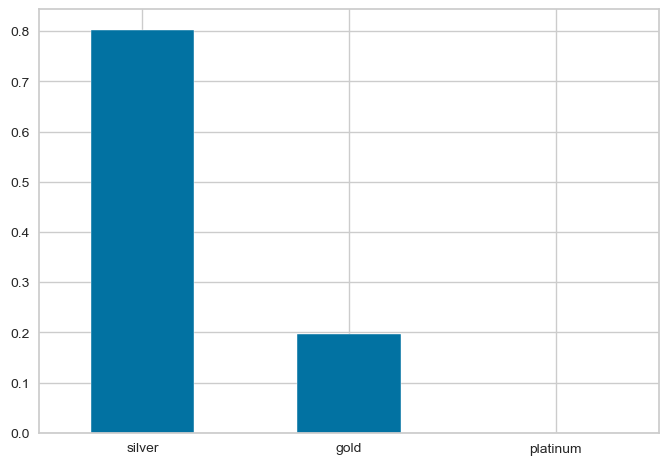

In [75]:
clu1['RFM_class'].value_counts(1).plot.bar(rot=0) # 0번 클러스터에는 sliver 고객이 많음

In [76]:
clu1 = clu1.reset_index()
clu1

,user_id,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class,Cluster
0,384989212,14,1,41.439999,3,1,1,311,5,silver,1
1,401021311,11,1,231.639999,3,1,3,313,7,silver,1
2,424869855,8,1,88.290001,4,1,1,411,6,silver,1
3,431246706,9,1,170.830002,4,1,2,412,7,silver,1
4,433754231,30,1,321.730011,1,1,3,113,5,silver,1
...,...,...,...,...,...,...,...,...,...,...,...
82877,564800747,5,1,12.840000,4,4,1,441,9,gold,1
82878,564853008,4,1,8.730000,5,4,1,541,10,gold,1
82879,564928973,4,1,7.930000,5,4,1,541,10,gold,1
82880,565120631,4,1,8.490000,5,4,1,541,10,gold,1


In [77]:
idx1 = clu1['user_id'].to_list()
idx1[:5]

[384989212, 401021311, 424869855, 431246706, 433754231]

In [78]:
df_user1 = total[(total['event_type'] == 'purchase') & (total['user_id'].isin(idx1))]
df_user1

,event_time,event_type,product_id,category_code,brand,price,user_id
53,2019-10-16 12:04:39+00:00,purchase,1004750,electronics.smartphone,samsung,195.619995,560839537
84,2019-10-16 12:04:41+00:00,purchase,1004834,electronics.smartphone,samsung,173.389999,545171410
406,2019-10-16 12:04:58+00:00,purchase,5100377,electronics.clocks,xiaomi,70.529999,560796347
744,2019-10-16 12:05:15+00:00,purchase,3601405,appliances.kitchen.washer,beko,180.160004,531195883
775,2019-10-16 12:05:17+00:00,purchase,3701134,appliances.environment.vacuum,bosch,105.279999,523136092
...,...,...,...,...,...,...,...
7072819,2019-10-11 17:53:21+00:00,purchase,4804056,electronics.audio.headphone,apple,160.880005,512402901
7073138,2019-10-11 17:53:37+00:00,purchase,4803653,electronics.audio.headphone,harper,38.330002,536500818
7073793,2019-10-11 17:54:05+00:00,purchase,1004785,electronics.smartphone,huawei,272.049988,559132868
7073974,2019-10-11 17:54:12+00:00,purchase,1004962,electronics.smartphone,nokia,128.490005,553843399


<Axes: >

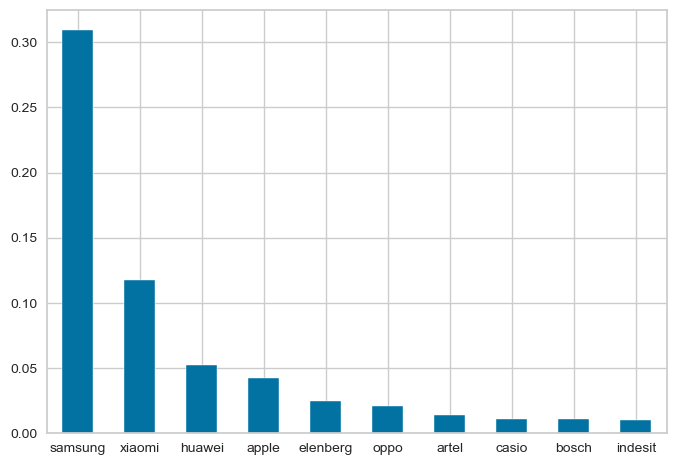

In [79]:
df_user1['brand'].value_counts(1).head(10).plot.bar(rot=0)

<Axes: >

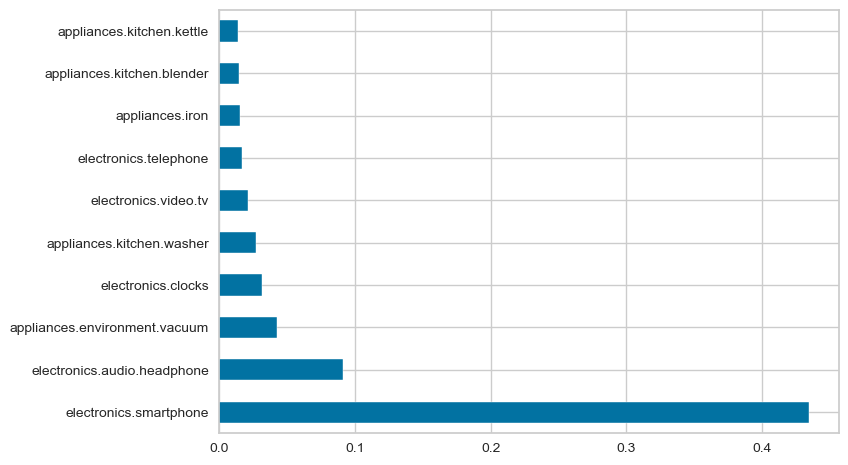

In [80]:
df_user1['category_code'].value_counts(1).head(10).plot.barh(rot=0)

#### 2번 집단

In [81]:
clu2 = df[df['Cluster'] == 2]
clu2

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class,Cluster
user_id,,,,,,,,,,
475786534,23,6,1551.590088,2,5,5,255,12,platinum,2
489085769,11,8,897.750000,3,5,4,354,12,platinum,2
492103460,24,6,2157.790039,2,5,5,255,12,platinum,2
493690536,11,4,1095.280029,3,5,5,355,13,platinum,2
497226076,2,14,10488.480469,5,5,5,555,15,platinum,2
...,...,...,...,...,...,...,...,...,...,...
566209184,1,3,1597.709961,5,5,5,555,15,platinum,2
566213717,1,3,2167.200195,5,5,5,555,15,platinum,2
566215463,1,4,1725.520020,5,5,5,555,15,platinum,2


<Axes: >

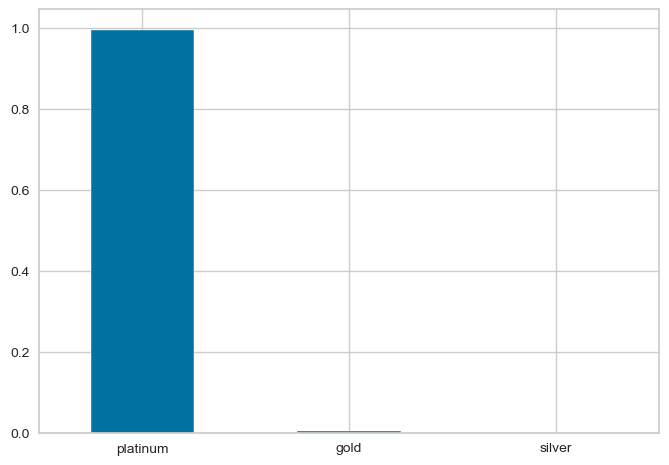

In [82]:
clu2['RFM_class'].value_counts(1).plot.bar(rot=0) # 2번 클러스터에는 platinum 고객이 많음

In [83]:
clu2 = clu2.reset_index()
clu2

,user_id,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class,Cluster
0,475786534,23,6,1551.590088,2,5,5,255,12,platinum,2
1,489085769,11,8,897.750000,3,5,4,354,12,platinum,2
2,492103460,24,6,2157.790039,2,5,5,255,12,platinum,2
3,493690536,11,4,1095.280029,3,5,5,355,13,platinum,2
4,497226076,2,14,10488.480469,5,5,5,555,15,platinum,2
...,...,...,...,...,...,...,...,...,...,...,...
23236,566209184,1,3,1597.709961,5,5,5,555,15,platinum,2
23237,566213717,1,3,2167.200195,5,5,5,555,15,platinum,2
23238,566215463,1,4,1725.520020,5,5,5,555,15,platinum,2
23239,566229570,1,4,4509.089844,5,5,5,555,15,platinum,2


In [84]:
idx2 = clu2['user_id'].to_list()
idx2[:5]

[475786534, 489085769, 492103460, 493690536, 497226076]

In [85]:
df_user2 = total[(total['event_type'] == 'purchase') & (total['user_id'].isin(idx2))]
df_user2

,event_time,event_type,product_id,category_code,brand,price,user_id
178,2019-10-16 12:04:46+00:00,purchase,1005105,electronics.smartphone,apple,1424.209961,514778102
214,2019-10-16 12:04:48+00:00,purchase,1002544,electronics.smartphone,apple,460.109985,522354527
295,2019-10-16 12:04:52+00:00,purchase,1003312,electronics.smartphone,apple,699.799988,517222549
479,2019-10-16 12:05:03+00:00,purchase,1005135,electronics.smartphone,apple,1741.359985,536590960
572,2019-10-16 12:05:07+00:00,purchase,1004835,electronics.smartphone,samsung,225.190002,517728689
...,...,...,...,...,...,...,...
7072217,2019-10-11 17:52:55+00:00,purchase,3800490,appliances.iron,maxwell,15.190000,528301732
7072966,2019-10-11 17:53:28+00:00,purchase,4804055,electronics.audio.headphone,apple,191.589996,512390049
7073479,2019-10-11 17:53:52+00:00,purchase,1003306,electronics.smartphone,apple,581.380005,517453153
7073703,2019-10-11 17:54:02+00:00,purchase,1004237,electronics.smartphone,apple,1085.969971,550623432


<Axes: >

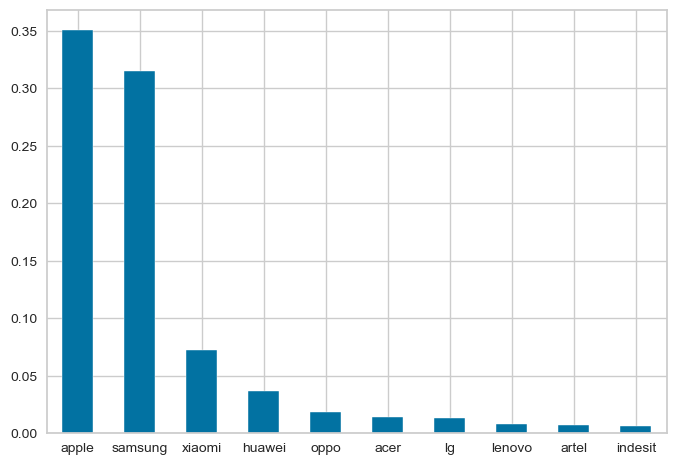

In [86]:
df_user2['brand'].value_counts(1).head(10).plot.bar(rot=0)

<Axes: >

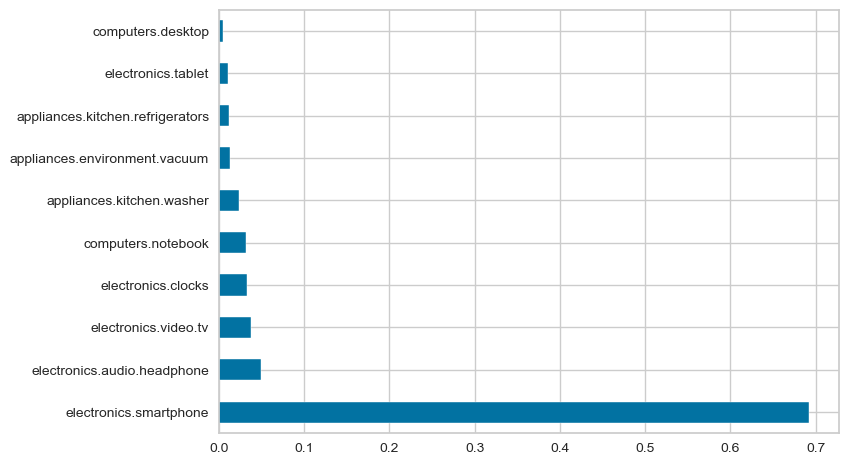

In [87]:
df_user2['category_code'].value_counts(1).head(10).plot.barh(rot=0)

#### 3번 집단

In [88]:
clu3 = df[df['Cluster'] == 3]
clu3

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class,Cluster
user_id,,,,,,,,,,
403013066,14,2,807.160034,3,4,4,344,11,platinum,3
420935067,25,1,385.839996,2,1,3,213,6,silver,3
435648894,26,1,388.130005,1,1,3,113,5,silver,3
435786120,14,1,437.850006,3,1,4,314,8,gold,3
437371552,30,2,358.289978,1,4,3,143,8,gold,3
...,...,...,...,...,...,...,...,...,...,...
564751628,5,2,1625.109863,4,5,5,455,14,platinum,3
564759853,5,2,3326.979980,4,5,5,455,14,platinum,3
564791602,5,2,1578.719971,4,5,5,455,14,platinum,3


<Axes: >

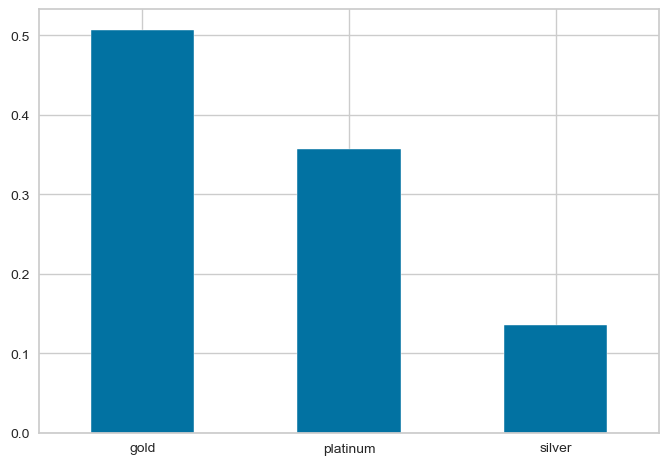

In [89]:
clu3['RFM_class'].value_counts(1).plot.bar(rot=0) # 3번 클러스터에는 sliver & gold 고객이 많음 

In [90]:
clu3 = clu3.reset_index()
clu3

,user_id,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class,Cluster
0,403013066,14,2,807.160034,3,4,4,344,11,platinum,3
1,420935067,25,1,385.839996,2,1,3,213,6,silver,3
2,435648894,26,1,388.130005,1,1,3,113,5,silver,3
3,435786120,14,1,437.850006,3,1,4,314,8,gold,3
4,437371552,30,2,358.289978,1,4,3,143,8,gold,3
...,...,...,...,...,...,...,...,...,...,...,...
66552,564751628,5,2,1625.109863,4,5,5,455,14,platinum,3
66553,564759853,5,2,3326.979980,4,5,5,455,14,platinum,3
66554,564791602,5,2,1578.719971,4,5,5,455,14,platinum,3
66555,564795691,5,2,2125.570068,4,5,5,455,14,platinum,3


In [91]:
idx3 = clu3['user_id'].to_list()
idx3[:5]

[403013066, 420935067, 435648894, 435786120, 437371552]

In [92]:
df_user3 = total[(total['event_type'] == 'purchase') & (total['user_id'].isin(idx3))]
df_user3

,event_time,event_type,product_id,category_code,brand,price,user_id
193,2019-10-16 12:04:47+00:00,purchase,1801900,electronics.video.tv,samsung,483.459991,551965553
299,2019-10-16 12:04:53+00:00,purchase,5100337,electronics.clocks,apple,346.730011,557340628
376,2019-10-16 12:04:56+00:00,purchase,1306732,computers.notebook,asus,360.109985,519274715
528,2019-10-16 12:05:05+00:00,purchase,1005105,electronics.smartphone,apple,1424.209961,547014958
541,2019-10-16 12:05:06+00:00,purchase,1002524,electronics.smartphone,apple,537.719971,516606449
...,...,...,...,...,...,...,...
7073949,2019-10-11 17:54:12+00:00,purchase,1004903,electronics.smartphone,huawei,111.699997,557936786
7074097,2019-10-11 17:54:18+00:00,purchase,1004249,electronics.smartphone,apple,766.760010,559250735
7074484,2019-10-11 17:54:35+00:00,purchase,1005112,electronics.smartphone,apple,1003.849976,512404459
7074507,2019-10-11 17:54:35+00:00,purchase,1005115,electronics.smartphone,apple,1003.849976,540273893


<Axes: >

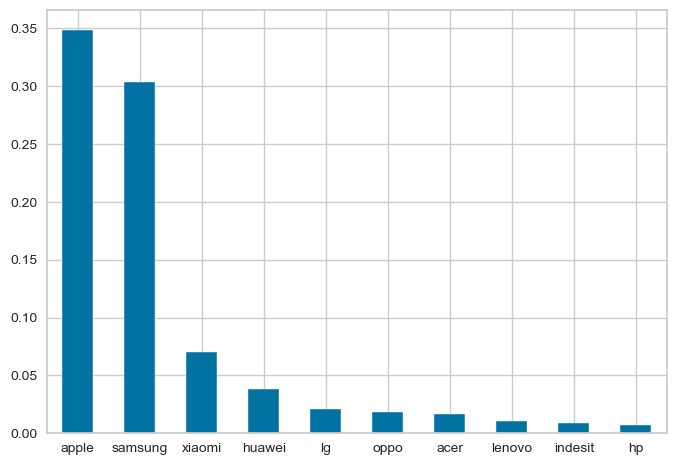

In [93]:
df_user3['brand'].value_counts(1).head(10).plot.bar(rot=0)

<Axes: >

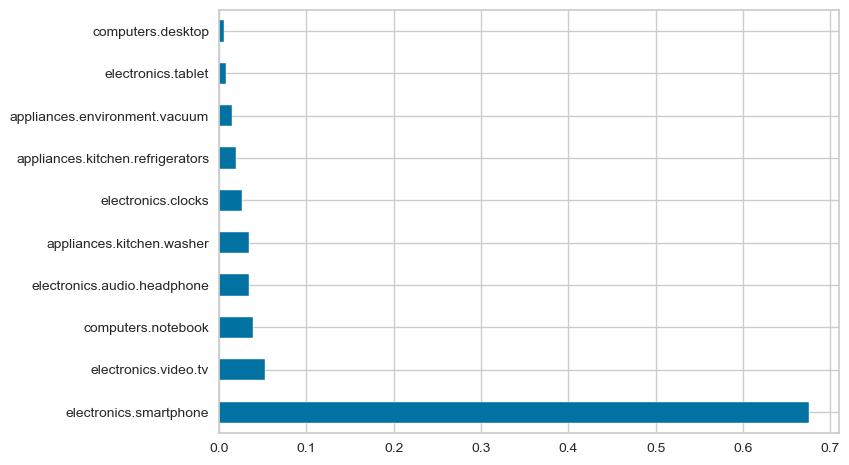

In [94]:
df_user3['category_code'].value_counts(1).head(10).plot.barh(rot=0)

### 집단별 고객 클래스 비교

In [95]:
clu0['RFM_class'].value_counts(1) # 0번 클러스터에는 platinum & gold 고객이 많음 

platinum    0.460682
gold        0.454921
silver      0.084397
Name: RFM_class, dtype: float64

In [96]:
clu1['RFM_class'].value_counts(1) # 1번 클러스터에는 sliver 고객이 많음 

silver      0.803323
gold        0.196569
platinum    0.000109
Name: RFM_class, dtype: float64

In [97]:
clu2['RFM_class'].value_counts(1) # 2번 클러스터에는 platinum 고객이 많음 

platinum    0.995396
gold        0.004518
silver      0.000086
Name: RFM_class, dtype: float64

In [98]:
clu3['RFM_class'].value_counts(1) # 3번 클러스터에는 gold 고객이 많음

gold        0.507445
platinum    0.357168
silver      0.135388
Name: RFM_class, dtype: float64

## 카테고리별 집단 고객 수 비교

<Axes: >

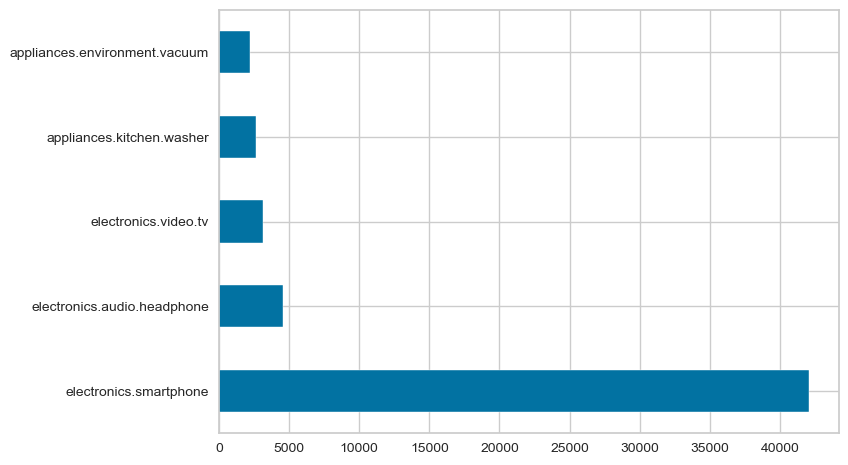

In [99]:
df_user0['category_code'].value_counts().head().plot.barh()

<Axes: >

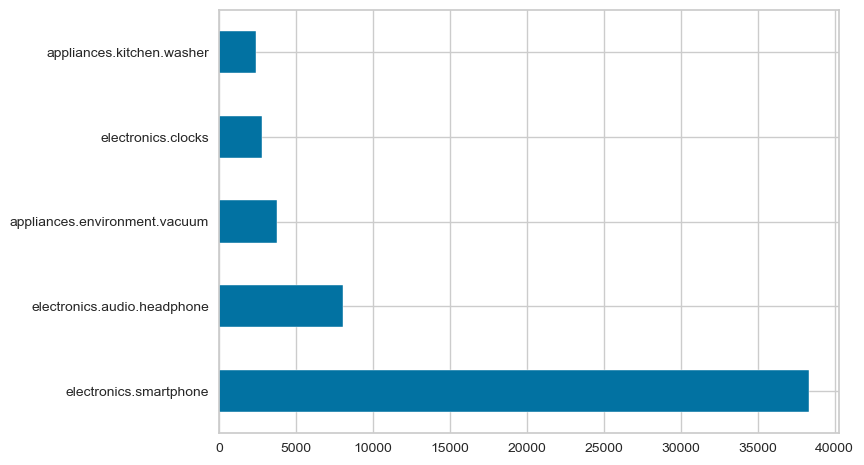

In [100]:
df_user1['category_code'].value_counts().head().plot.barh()

<Axes: >

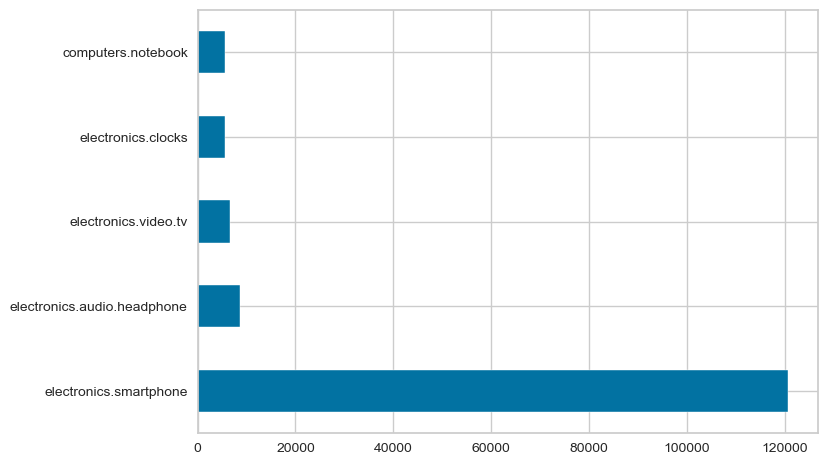

In [101]:
df_user2['category_code'].value_counts().head().plot.barh()

<Axes: >

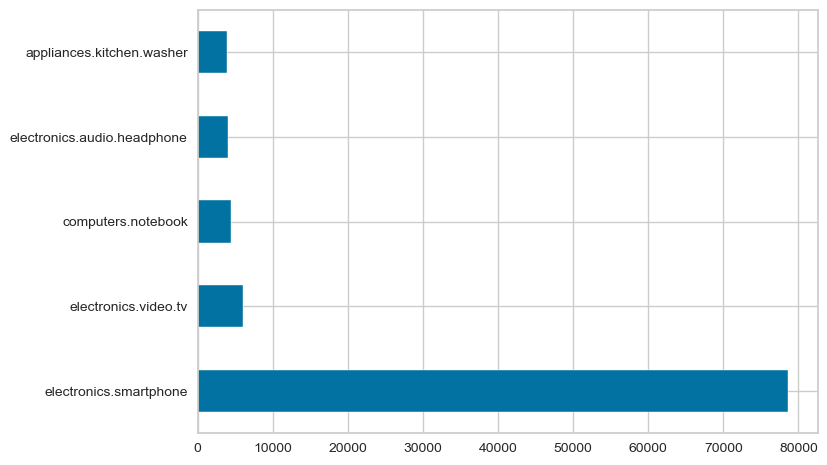

In [102]:
df_user3['category_code'].value_counts().head().plot.barh()

## 브랜드별 집단 고객 수 비교

<Axes: xlabel='brand'>

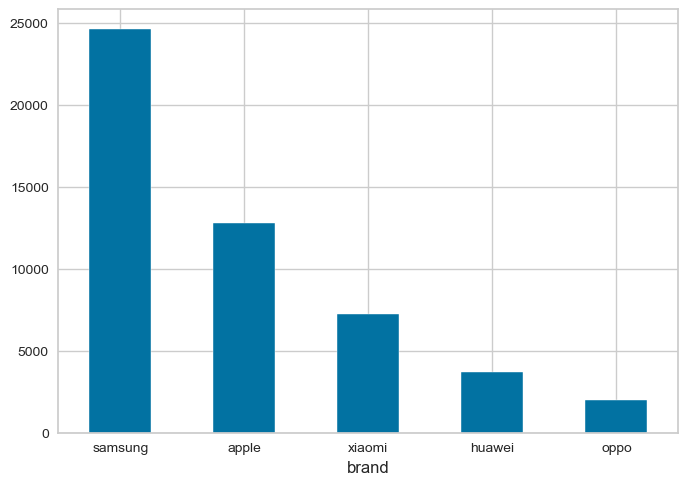

In [103]:
df_user0.groupby('brand')['user_id'].count().sort_values(ascending=False).head().plot.bar(rot=0)

<Axes: xlabel='brand'>

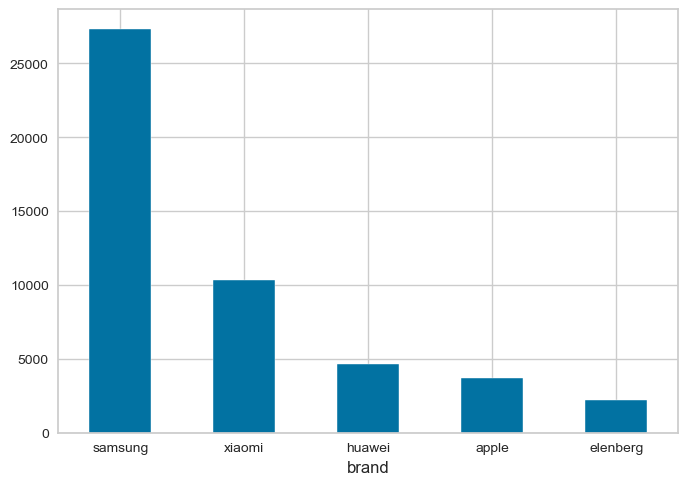

In [104]:
df_user1.groupby('brand')['user_id'].count().sort_values(ascending=False).head().plot.bar(rot=0)

<Axes: xlabel='brand'>

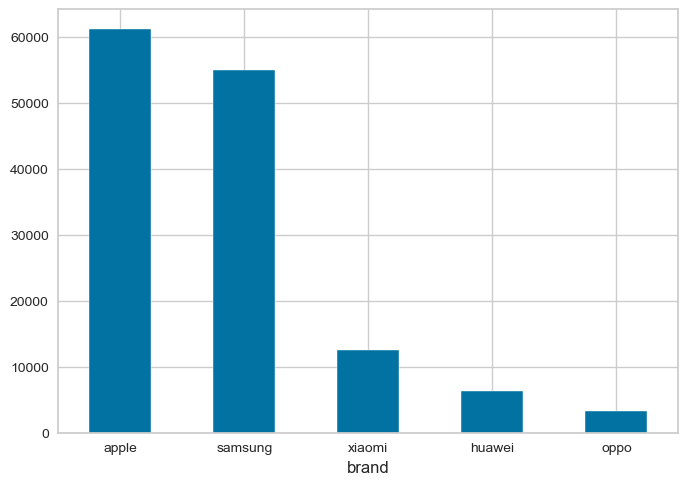

In [105]:
df_user2.groupby('brand')['user_id'].count().sort_values(ascending=False).head().plot.bar(rot=0)

<Axes: xlabel='brand'>

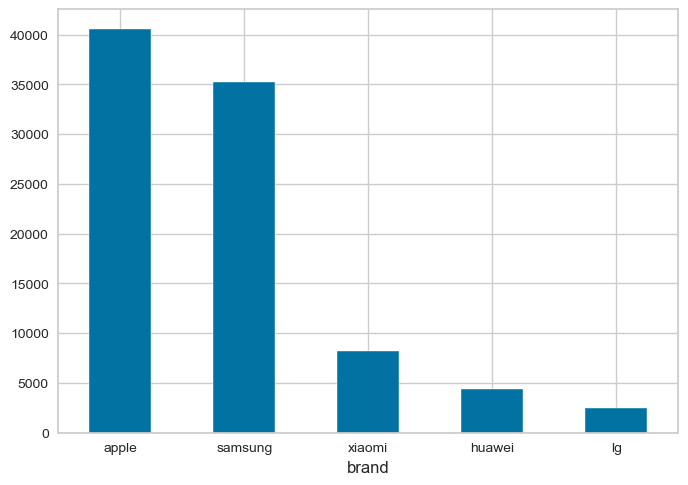

In [106]:
df_user3.groupby('brand')['user_id'].count().sort_values(ascending=False).head().plot.bar(rot=0)